In [237]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,\
                                    cross_val_score,\
                                    KFold,\
                                    GridSearchCV,\
                                    RandomizedSearchCV
from skopt import BayesSearchCV
from scipy import stats
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,\
                            accuracy_score,\
                            confusion_matrix
from sklearn.naive_bayes import GaussianNB,\
                                MultinomialNB,\
                                BernoulliNB,\
                                ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
import scipy.stats as ss
import time

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('C:/Users/DNS/.cache/kagglehub/datasets/henriqueyamahata/bank-marketing/versions/1/bank-additional-full.csv', sep = ';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Данные связаны с прямыми маркетинговыми кампаниями (телефонные звонки) португальского банковского учреждения. Цель классификации — предсказать, подпишется ли клиент на срочный депозит (переменная y).

Поля:
1. Возраст клиента
2. Занятость (Профессия)
3. Семейное положение
4. Образование
5. Наличие кредита
6. Наличие жилья
7. Наличие ссуды (?loan?)
8. Тип связи
9. Месяц (последний контакт)
10. День недели (последний контакт)
11. Длительность последнего звонка
12. Компания (количество совершенных звонков для этого клиента в рамках этой кампании)
13. Количество дней, прошедших со времени последнего контакта (999 - контакта ранее не было)
14. Количество контактов, выполненных для этого клиента до текущей кампании
15. Результат предыдущей кампании
16. Темп изменения занятости
17. Индекс потребительских цен
18. Индекс потребительской уверенности
19. Ставка за 3 месяца (???)
20. Количество сотрудников (???)
21. Целевая метка - подписался клиент на срочный депозит или нет

In [6]:
data = data.drop(['day_of_week', 'month'], axis = 1)

In [8]:
data.y = data.y.apply(lambda x: 0 if x=='no'\
                  else 1)
data.contact = data.contact.apply(lambda x: 0 if x == 'telephone'\
                                  else 1)

data.job = data.job.apply(lambda x: -1 if x == 'unknown'\
                          else 1 if x == 'unemployed'\
                          else 2 if x == 'housemaid'\
                          else 3 if x == 'services'\
                          else 4 if x == 'admin.'\
                          else 5 if x == 'blue-collar'\
                          else 6 if x == 'technician'\
                          else 7 if x == 'retired'\
                          else 8 if x == 'management'\
                          else 9 if x == 'self-employed'\
                          else 10 if x == 'entrepreneur'\
                          else 11)

data.marital = data.marital.apply(lambda x: -1 if x == 'unknown'\
                                 else 1 if x == 'married'\
                                 else 2 if x == 'single'\
                                 else 3)

data.education = data.education.apply(lambda x: -1 if x == 'unknown'\
                                     else 1 if x in ('basic.4y', 'basic.6y', 'basic.9y')\
                                     else 2 if x == 'high.school'\
                                     else 3 if x == 'professional.course'\
                                     else 4 if x == 'university.degree'\
                                     else 5)

data.default = data.default.apply(lambda x: 0 if x == 'no'\
                              else 1 if x=='yes'\
                              else -1)

data.housing = data.housing.apply(lambda x: 0 if x == 'no'\
                              else 1 if x == 'yes'\
                              else -1)

data.loan = data.loan.apply(lambda x: 0 if x == 'no'\
                        else 1 if x == 'yes'\
                        else -1)

data.poutcome = data.poutcome.apply(lambda x: 0 if x == 'failure'\
                                else 2 if x == 'success'\
                                else -1)

data.pdays = data.pdays.apply(lambda x: -1 if x==999\
                          else 1 if x<=10\
                          else 2 if x<=20\
                          else 3)

In [10]:
data_columns = data.columns

In [12]:
n_scaler = MinMaxScaler()
data_norm = n_scaler.fit_transform(data)

data = pd.DataFrame(data_norm, columns = data_columns)
data.head()

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,0.250000,0.5,0.333333,0.5,0.5,0.5,0.0,0.053070,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
1,0.493827,0.333333,0.5,0.500000,0.0,0.5,0.5,0.0,0.030297,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
2,0.246914,0.333333,0.5,0.500000,0.5,1.0,0.5,0.0,0.045954,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
3,0.283951,0.416667,0.5,0.333333,0.5,0.5,0.5,0.0,0.030704,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
4,0.481481,0.333333,0.5,0.500000,0.5,0.5,1.0,0.0,0.062424,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0


In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,0.284248,0.128657,0.0,0.185185,0.259259,0.370370,1.0
job,41188.0,0.519409,0.180056,0.0,0.416667,0.500000,0.583333,1.0
marital,41188.0,0.625231,0.174215,0.0,0.500000,0.500000,0.750000,1.0
education,41188.0,0.548262,0.230408,0.0,0.333333,0.500000,0.833333,1.0
default,41188.0,0.395673,0.203265,0.0,0.500000,0.500000,0.500000,1.0
housing,41188.0,0.749903,0.272983,0.0,0.500000,1.000000,1.000000,1.0
loan,41188.0,0.563829,0.199648,0.0,0.500000,0.500000,0.500000,1.0
contact,41188.0,0.634748,0.481507,0.0,0.000000,1.000000,1.000000,1.0
duration,41188.0,0.052518,0.052720,0.0,0.020740,0.036600,0.064864,1.0
campaign,41188.0,0.028502,0.050364,0.0,0.000000,0.018182,0.036364,1.0


In [16]:
X = data.drop('y', axis = 1)
y = data.y

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

Продемонстрировать сохранение свойств исходного датасета при разбиении на тренировочную и тестовую (например, сохранения типа распределения) части для пользовательских и/или модельных данных.



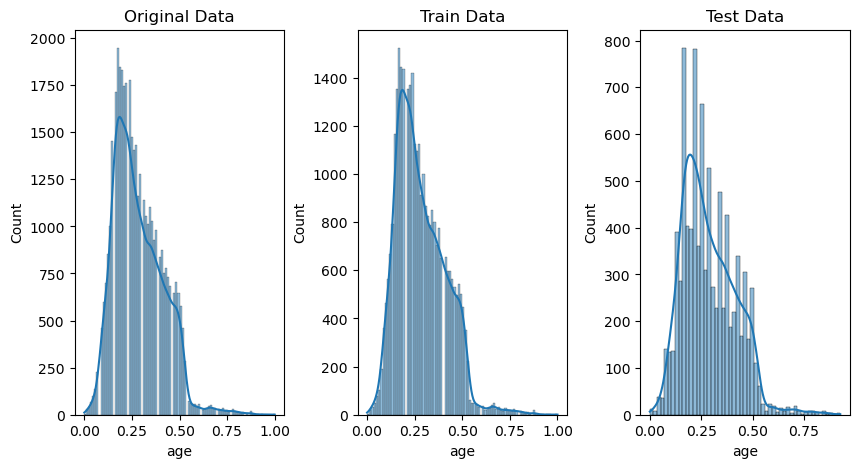

In [21]:
fig = plt.subplots(1, 3, figsize = (10,5))
plt.subplots_adjust(wspace = 0.35, hspace = 0.2)

plt.subplot(1,3,1)
sns.histplot(data.age, kde = True).set_title('Original Data')

plt.subplot(1,3,2)
sns.histplot(X_train.age, kde = True).set_title('Train Data')

plt.subplot(1,3,3)
sns.histplot(X_test.age, kde = True).set_title('Test Data')

plt.show()

In [23]:
print(f'Original Data: {stats.shapiro(data.age)}')
print(f'Train Data: {stats.shapiro(X_train.age)}')
print(f'Original Data: {stats.shapiro(X_test.age)}')

Original Data: ShapiroResult(statistic=0.9572414615024899, pvalue=5.4319443630172027e-73)
Train Data: ShapiroResult(statistic=0.9565150171784633, pvalue=1.474008549473412e-68)
Original Data: ShapiroResult(statistic=0.9595757380847807, pvalue=1.9302046448376108e-44)


In [187]:
# Проверка на равенство дисперсий
print(f'Original-Train Data: {ss.levene(data.age, X_train.age, center = 'mean')}')
print(f'Original-Test Data: {ss.levene(data.age, X_test.age, center = 'mean')}')

Original-Train Data: LeveneResult(statistic=0.014885579888692822, pvalue=0.9028942248427991)
Original-Test Data: LeveneResult(statistic=0.08837789764762545, pvalue=0.7662507694867113)


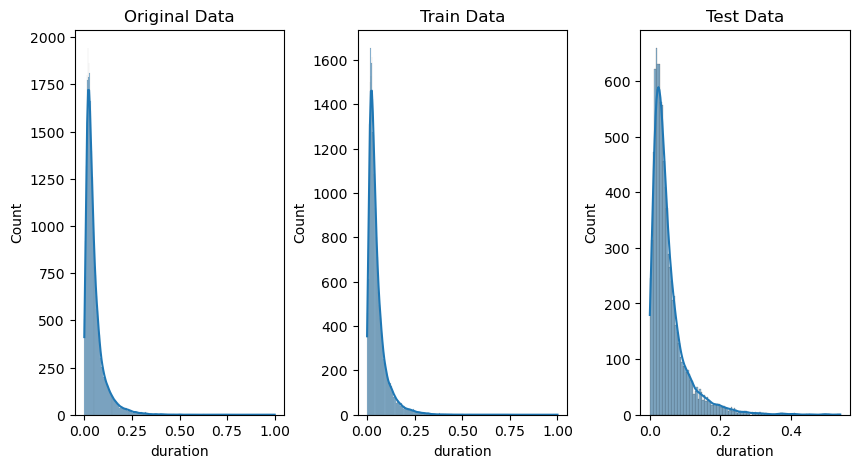

In [25]:
fig = plt.subplots(1, 3, figsize = (10,5))
plt.subplots_adjust(wspace = 0.35, hspace = 0.2)

plt.subplot(1,3,1)
sns.histplot(data.duration, kde = True).set_title('Original Data')

plt.subplot(1,3,2)
sns.histplot(X_train.duration, kde = True).set_title('Train Data')

plt.subplot(1,3,3)
sns.histplot(X_test.duration, kde = True).set_title('Test Data')

plt.show()

In [27]:
print(f'Original Data: {stats.shapiro(data.duration)}')
print(f'Train Data: {stats.shapiro(X_train.duration)}')
print(f'Original Data: {stats.shapiro(X_test.duration)}')

Original Data: ShapiroResult(statistic=0.7216534008376545, pvalue=1.8019507851584057e-119)
Train Data: ShapiroResult(statistic=0.718094581820315, pvalue=2.1294903106584623e-113)
Original Data: ShapiroResult(statistic=0.7333502720011956, pvalue=1.447468451951134e-80)


In [189]:
print(f'Original-Train Data: {ss.levene(data.duration, X_train.duration, center = 'mean')}')
print(f'Original-Test Data: {ss.levene(data.duration, X_test.duration, center = 'mean')}')

Original-Train Data: LeveneResult(statistic=0.14819149650117008, pvalue=0.7002707712497214)
Original-Test Data: LeveneResult(statistic=0.7700443477522884, pvalue=0.3802075288757776)


In [29]:
data.drop('y', axis = 1).describe().T.tail()

,count,mean,std,min,25%,50%,75%,max
emp.var.rate,41188.0,0.725393,0.327283,0.0,0.333333,0.937500,1.000000,1.0
cons.price.idx,41188.0,0.535723,0.225581,0.0,0.340608,0.603274,0.698753,1.0
cons.conf.idx,41188.0,0.430854,0.193648,0.0,0.338912,0.376569,0.602510,1.0
euribor3m,41188.0,0.677237,0.393210,0.0,0.160961,0.957379,0.980957,1.0
nr.employed,41188.0,0.769134,0.273163,0.0,0.512287,0.859735,1.000000,1.0


In [31]:
X_train.describe().T.tail()

,count,mean,std,min,25%,50%,75%,max
emp.var.rate,32126.0,0.725822,0.327698,0.0,0.333333,0.937500,1.000000,1.0
cons.price.idx,32126.0,0.535852,0.225535,0.0,0.340608,0.603274,0.698753,1.0
cons.conf.idx,32126.0,0.431036,0.193718,0.0,0.338912,0.376569,0.602510,1.0
euribor3m,32126.0,0.677825,0.393190,0.0,0.160961,0.957379,0.980957,1.0
nr.employed,32126.0,0.769471,0.273362,0.0,0.512287,0.859735,1.000000,1.0


In [33]:
X_test.describe().T.tail()

,count,mean,std,min,25%,50%,75%,max
emp.var.rate,9062.0,0.723870,0.325823,0.0,0.333333,0.937500,1.000000,1.0
cons.price.idx,9062.0,0.535263,0.225754,0.0,0.340608,0.484412,0.698753,1.0
cons.conf.idx,9062.0,0.430208,0.193412,0.0,0.338912,0.376569,0.602510,1.0
euribor3m,9062.0,0.675150,0.393293,0.0,0.160961,0.957379,0.980957,1.0
nr.employed,9062.0,0.767937,0.272467,0.0,0.512287,0.859735,1.000000,1.0


Реализовать процедуру перекрестной проверки для пользовательских и/или модельных данных. Продемонстрировать процесс наглядно.

In [42]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

print(f'LightGBM Accuracy: {round(accuracy_score(y_test, lgbm_pred), 2)*100}')

[LightGBM] [Info] Number of positive: 3620, number of negative: 28506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 32126, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112681 -> initscore=-2.063641
[LightGBM] [Info] Start training from score -2.063641
LightGBM Accuracy: 92.0


In [44]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [46]:
LGBM = cross_val_score(lgbm, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy')
LGBM_mean = LGBM.mean()

[LightGBM] [Info] Number of positive: 3256, number of negative: 25657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 28913, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112614 -> initscore=-2.064317
[LightGBM] [Info] Start training from score -2.064317
[LightGBM] [Info] Number of positive: 3277, number of negative: 25636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 28913, number of used features: 18
[LightGBM] [Info] [bin

In [48]:
print(f'Cross validation: {LGBM}')
print(f'Cross validation score: {LGBM_mean}')

Cross validation: [0.90849673 0.92156863 0.92187986 0.92343604 0.9178338  0.91596639
 0.91469489 0.91407223 0.91002491 0.91687422]
Cross validation score: 0.9164847701914584


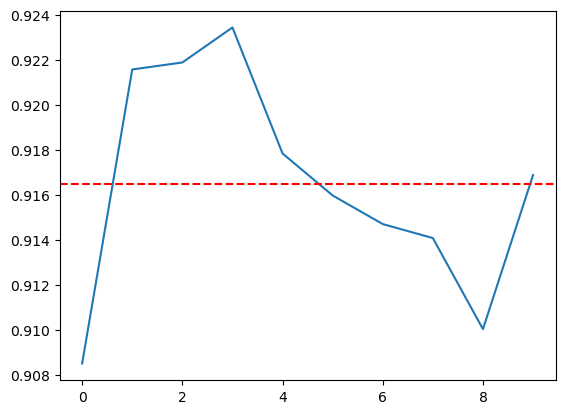

In [50]:
sns.lineplot(LGBM)
plt.axhline(y=0.9164847701914584, color='r', linestyle='--')
plt.show()

Для пользовательских и/или модельных данных реализовать сравнение скорости и точности результатов методов после применения перебора гиперпараметров по сетке, методом случайного поиска и с использованием байесовской оптимизации.

In [219]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

print(f'Decision Tree Classification(entropy) Accuracy: {round(accuracy_score(y_test, dtree_pred), 2)*100}')

Decision Tree Classification(entropy) Accuracy: 89.0


In [221]:
params = [{'criterion':['entropy', 'gini'], 'min_samples_leaf':[5, 10, 20, 50, 100], 'max_depth':[5, 10, 20, 50, 100]}]

In [225]:
#Grid Search
start_time = time.time()
grid_search = GridSearchCV(estimator = dtree,
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
duration = time.time() - start_time

best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Accuracy: {round(best_accuracy, 2)*100}')
print(f'Best Parameters: {best_params}')
print(f'Duration: {duration}')

Accuracy: 91.0
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
Duration: 11.781456232070923


In [229]:
#Random Search
start_time = time.time()
random_search = RandomizedSearchCV(estimator = dtree,
                           param_distributions = params,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
random_search.fit(X_train, y_train)
duration = time.time() - start_time

best_accuracy = random_search.best_score_
best_params = random_search.best_params_

print(f'Accuracy: {round(best_accuracy, 2)*100}')
print(f'Best Parameters: {best_params}')
print(f'Duration: {duration}')

Accuracy: 91.0
Best Parameters: {'min_samples_leaf': 10, 'max_depth': 5, 'criterion': 'gini'}
Duration: 2.655153274536133


In [240]:
#Bayesian optimization
start_time = time.time()
Bayesian_opt = BayesSearchCV(estimator = dtree,
                             search_spaces = params,
                             scoring = 'accuracy',
                             cv = 10,
                             n_jobs = -1)
Bayesian_opt.fit(X_train, y_train)
duration = time.time() - start_time

best_accuracy = Bayesian_opt.best_score_
best_params = Bayesian_opt.best_params_

print(f'Accuracy: {round(best_accuracy, 2)*100}')
print(f'Best Parameters: {best_params}')
print(f'Duration: {duration}')

Accuracy: 91.0
Best Parameters: OrderedDict({'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10})
Duration: 116.89528799057007


In [242]:
dtree = DecisionTreeClassifier(criterion = 'gini',
                               max_depth = 5,
                               min_samples_leaf = 10)
dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

print(f'Decision Tree Classification(entropy) Accuracy: {round(accuracy_score(y_test, dtree_pred), 2)*100}')

Decision Tree Classification(entropy) Accuracy: 92.0


Для пользовательских и/или модельных данных реализовать Гауссовский наивный байесовский классификатор.

In [86]:
GNB_Classifier = GaussianNB()
GNB_Classifier.fit(X_train, y_train)
gnb_pred = GNB_Classifier.predict(X_test)

print(f'Gaussian NB Classification Accuracy: {round(accuracy_score(y_test, gnb_pred), 2)*100}')

Gaussian NB Classification Accuracy: 85.0


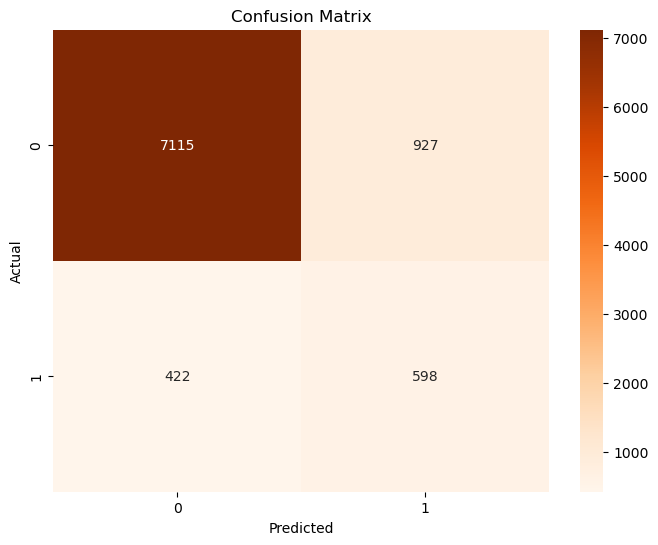

In [98]:
conf_matrix = confusion_matrix(y_test, gnb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Oranges")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Для несбалансированных пользовательских и/или модельных данных реализовать дополненный наивный байесовский классификатор.

<Axes: xlabel='y', ylabel='count'>

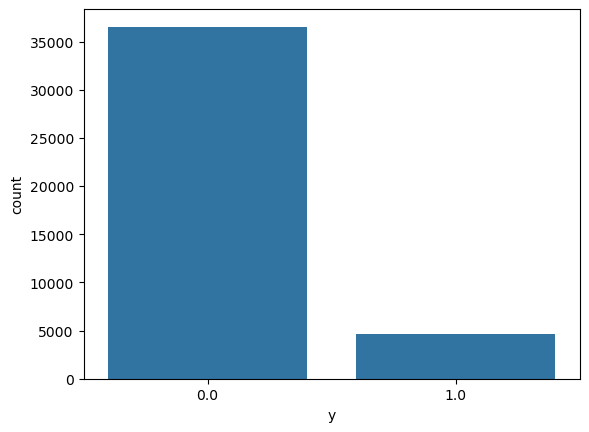

In [126]:
sns.countplot(data, x = "y")

In [100]:
CNB_Classifier = ComplementNB()
CNB_Classifier.fit(X_train, y_train)
cnb_pred = CNB_Classifier.predict(X_test)

print(f'Gaussian NB Classification Accuracy: {round(accuracy_score(y_test, cnb_pred), 2)*100}')

Gaussian NB Classification Accuracy: 72.0


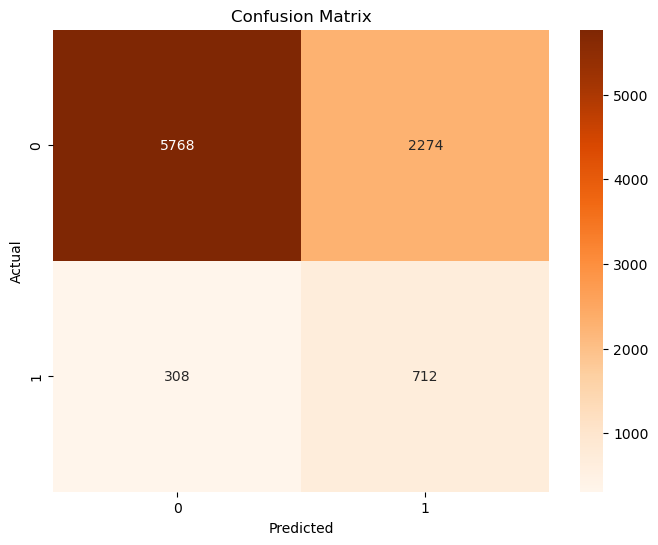

In [102]:
conf_matrix = confusion_matrix(y_test, cnb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Oranges")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Для пользовательских и/или модельных данных реализовать мультиномиальный наивный байесовский классификатор.

In [106]:
MultinomNB_Classifier = MultinomialNB()
MultinomNB_Classifier.fit(X_train, y_train)
mnb_pred = MultinomNB_Classifier.predict(X_test)

print(f'Multinomial NB Classification Accuracy: {round(accuracy_score(y_test, mnb_pred), 2)*100}')

Multinomial NB Classification Accuracy: 90.0


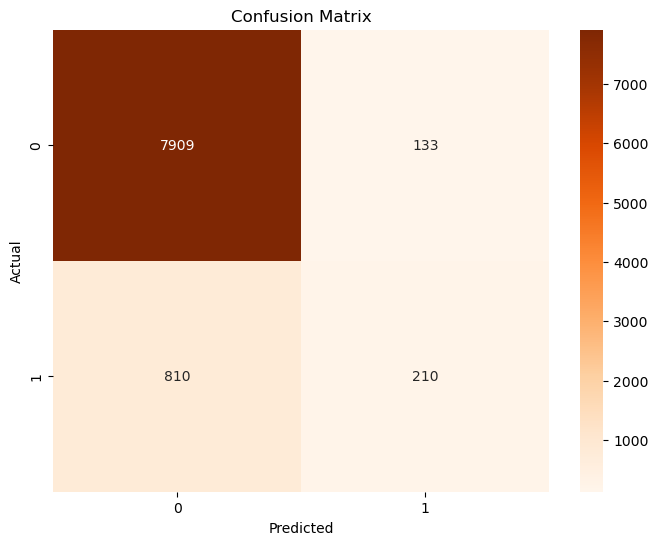

In [108]:
conf_matrix = confusion_matrix(y_test, mnb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Oranges")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Для пользовательских и/или модельных данных реализовать наивный байесовский классификатор Бернулли.

In [112]:
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, y_train)
bnb_pred = BNB_Classifier.predict(X_test)

print(f'Bernoulli NB Classification Accuracy: {round(accuracy_score(y_test, bnb_pred), 2)*100}')

Bernoulli NB Classification Accuracy: 86.0


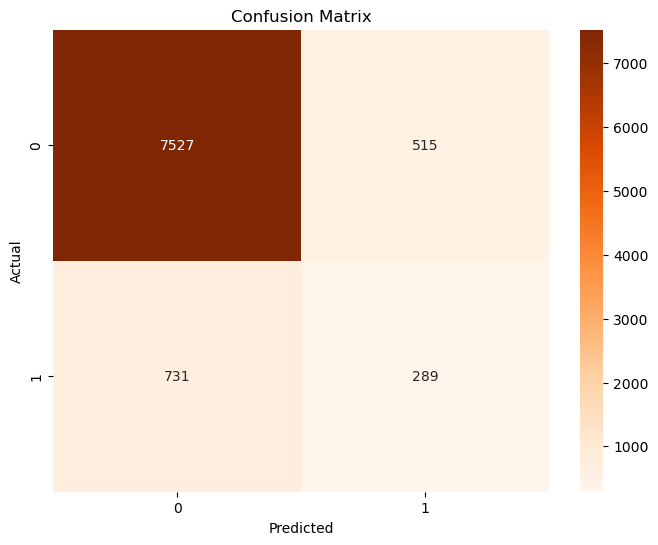

In [114]:
conf_matrix = confusion_matrix(y_test, bnb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Oranges")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Общее сравнение

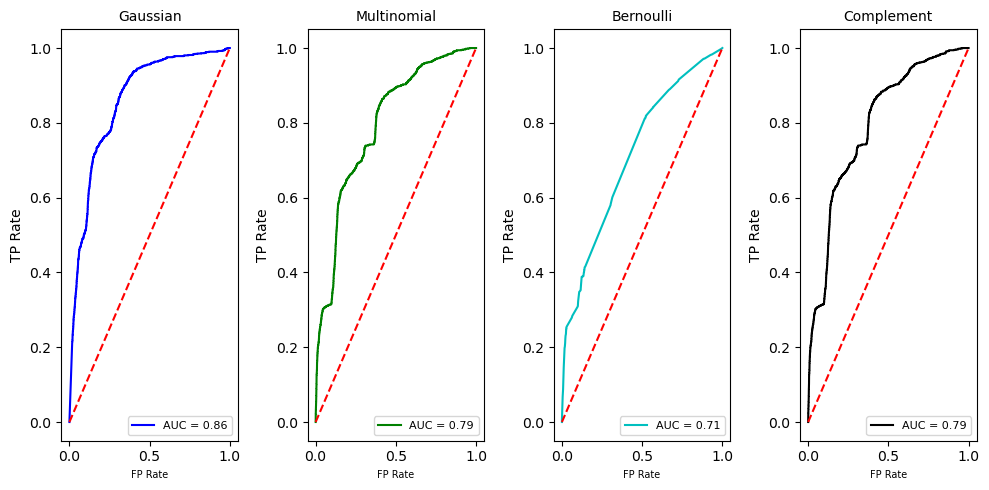

In [169]:
fig, ax_arr = plt.subplots(1,4, figsize = (10,5))

#Gaussian
probs = GNB_Classifier.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

plt.subplot(1,4,1)
plt.plot(fprlog, tprlog, 'b', label = f'AUC = {round(roc_auclog, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Gaussian',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 7)
plt.legend(loc = 'lower right', prop={'size': 8})

#Multinomial
probs = MultinomNB_Classifier.predict_proba(X_test)
preds = probs[:,1]
fprknn, tprknn, thresholdknn = metrics.roc_curve(y_test, preds)
roc_aucknn = metrics.auc(fprknn, tprknn)

plt.subplot(1,4,2)
plt.plot(fprknn, tprknn, 'g', label = f'AUC = {round(roc_aucknn, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Multinomial',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 7)
plt.legend(loc = 'lower right', prop={'size': 8})

#Bernoulli
probs = BNB_Classifier.predict_proba(X_test)
preds = probs[:,1]
fprsvc_rbf, tprsvc_rbf, thresholdsvc_rbf = metrics.roc_curve(y_test, preds)
roc_aucsvc_rbf = metrics.auc(fprsvc_rbf, tprsvc_rbf)

plt.subplot(1,4,3)
plt.plot(fprsvc_rbf, tprsvc_rbf, 'c', label = f'AUC = {round(roc_aucsvc_rbf, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Bernoulli',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 7)
plt.legend(loc = 'lower right', prop={'size': 8})

#Complement
probs = CNB_Classifier.predict_proba(X_test)
preds = probs[:,1]
fprsvc_sigmoid, tprsvc_sigmoid, thresholdsvc_sigmoid = metrics.roc_curve(y_test, preds)
roc_aucsvc_sigmoid = metrics.auc(fprsvc_sigmoid, tprsvc_sigmoid)

plt.subplot(1,4,4)
plt.plot(fprsvc_sigmoid, tprsvc_sigmoid, 'k', label = f'AUC = {round(roc_aucsvc_sigmoid, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Complement',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 7)
plt.legend(loc = 'lower right', prop={'size': 8})

plt.subplots_adjust(wspace=0.2)
plt.tight_layout()

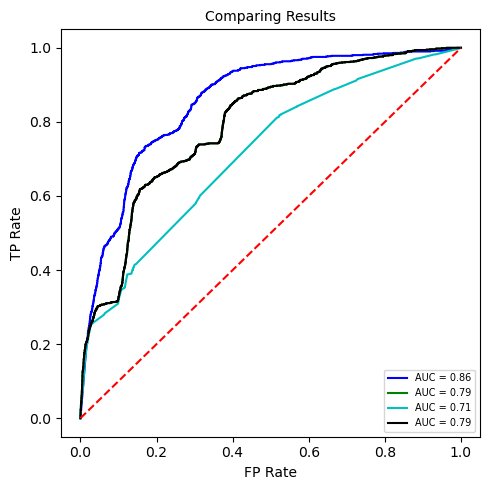

In [171]:
plt.figure(figsize = (5,5))

plt.plot(fprlog, tprlog, 'b', label = f'AUC = {round(roc_auclog, 2)}')
plt.plot(fprknn, tprknn, 'g', label = f'AUC = {round(roc_aucknn, 2)}')
plt.plot(fprsvc_rbf, tprsvc_rbf, 'c', label = f'AUC = {round(roc_aucsvc_rbf, 2)}')
plt.plot(fprsvc_sigmoid, tprsvc_sigmoid, 'k', label = f'AUC = {round(roc_aucsvc_sigmoid, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Comparing Results',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 10)
plt.legend(loc = 'lower right', prop = {'size': 7})

plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 